## **0. Tải bộ dữ liệu**

In [ ]:
# https://drive.google.com/file/d/1FC2P-NC8q_6cAqYIAkV4mBH5MCF1c-oc/view?usp=share_link
!gdown --id 1FC2P-NC8q_6cAqYIAkV4mBH5MCF1c-oc

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FC2P-NC8q_6cAqYIAkV4mBH5MCF1c-oc
To: /content/tesla_stock_price.zip
100% 34.1k/34.1k [00:00<00:00, 48.9MB/s]


In [ ]:
!unzip './tesla_stock_price.zip'

Archive:  ./tesla_stock_price.zip
  inflating: tesla_stock.csv         


## **1. Import các thư viện cần thiết**

In [ ]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

## **2. Trực quan hóa dữ liệu**

In [ ]:
dataset_filepath = './tesla_stock.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
df = pd.read_csv(dataset_filepath, index_col=0) # Đọc file .csv thành DataFrame
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692 entries, 6/29/2010 to 3/17/2017
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5+ KB


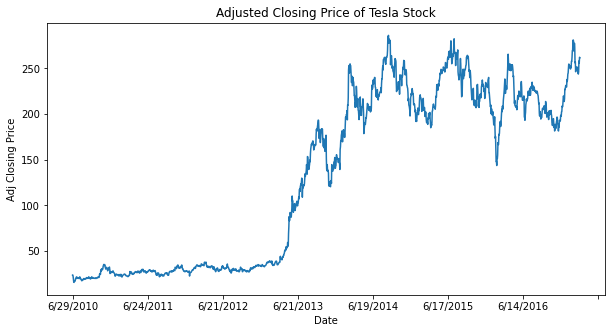

In [ ]:
plt.figure(figsize=(10, 5))
df['Adj Close'].plot()
plt.title('Adjusted Closing Price of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.show()

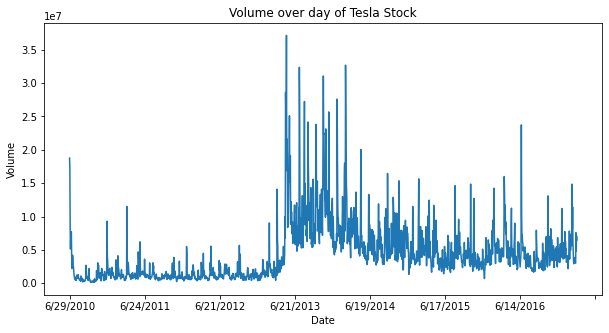

In [ ]:
plt.figure(figsize=(10, 5))
df['Volume'].plot()
plt.title('Volume over day of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## **3. Chuẩn bị dữ liệu**

In [ ]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:label_end_idx] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
INPUT_SIZE = 30 
LABEL_SIZE = 1 
OFFSET = 1
BATCH_SIZE = 32
TARGET_NAME = 'Adj Close'

In [ ]:
dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

## **4. Xây dựng mô hình**

In [ ]:
model = XGBRegressor()

## **5. Huấn luyện mô hình**

In [ ]:
model.fit(X_train, y_train)

[04:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

## **6. Đánh giá và trực quan hóa**

In [ ]:
def mae(y_true, y_pred):
    mae = np.mean(np.abs((y_true - y_pred)))

    return mae

def mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)

    return mse

def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))

    return rmse

def mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred) / y_true)) * 100

    return mape

In [ ]:
y_test_pred = model.predict(X_test)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 5.157651321931074
MAPE: 1.7249925331235518
MSE: 26.60136715861736
MAE: 3.7212925034285074


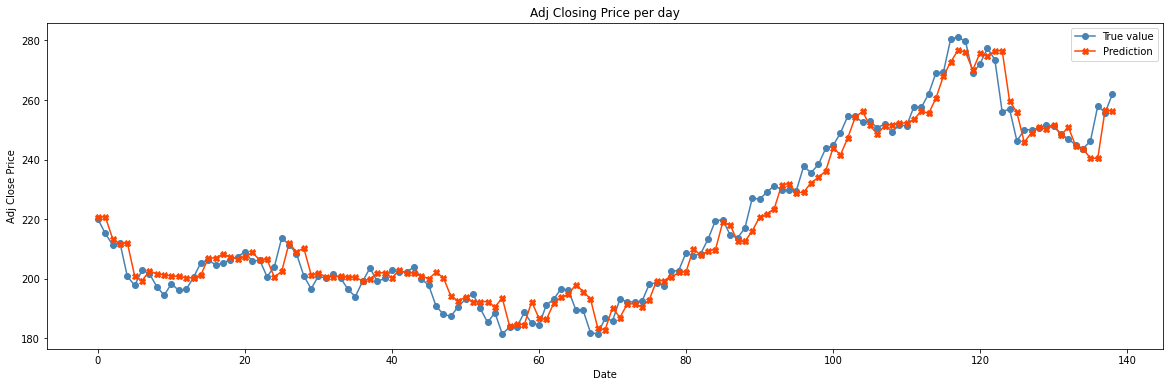

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Adj Closing Price per day')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test[:300], model.predict(X_test[:300]))